In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import snntorch as snn
from snntorch import utils
from snntorch import spikegen
import snntorch.spikeplot as splt
from snntorch import surrogate
from snntorch import functional

import matplotlib.pyplot as plt
import numpy as np

In [2]:


dtype=torch.float
torch.manual_seed(734)
print("Feedforward SNN Trained on MNIST")

# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# Training Parameters
batch_size=256
data_path='./tmp/data/mnist'
num_classes = 10  # MNIST has 10 output classes

# Define a transform
transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)

# # temporary dataloader if MNIST service is unavailable
# !wget www.di.ens.fr/~lelarge/MNIST.tar.gz
# !tar -zxvf MNIST.tar.gz

train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True,drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True,drop_last=True)

Feedforward SNN Trained on MNIST
Using device: cuda


In [3]:
################ MNIST Model ##############################################################

# layer parameters
num_inputs = 28*28
num_hidden1 = 200
num_hidden2 = 50
num_outputs = 10
num_steps = 26  # for spike encoding
beta = 0.95 #leak rate
lr=5e-3
#weight_decay=1e-6

spike_grad1 = surrogate.atan() 

class Net(nn.Module):

    def __init__(self):
        super().__init__()

        self.loss = functional.ce_count_loss()
        self.accuracy_metric = functional.accuracy_rate

        # initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden1)
        self.lif1 = snn.Leaky(beta=beta,spike_grad=spike_grad1)

        self.fc2 = nn.Linear(num_hidden1,num_hidden2)
        self.lif2 = snn.Leaky(beta=beta, spike_grad=spike_grad1)

        self.fc3 = nn.Linear(num_hidden2,num_outputs)
        self.lif3 = snn.Leaky(beta=beta, spike_grad=spike_grad1)

        #pytorch creates the tensors to represent the network layout and weights for each layer; snntorch provides the model that operates on the entire tensor (at each layer).

  
    def forward(self,x): #x is input data

        #spike encoding at input layer
        x_spk = spikegen.rate(x,num_steps=num_steps) 
        # Initialize hidden states
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif2.init_leaky()

        # record spike outputs and membrane potentials
        mem3_rec = []
        spk3_rec = []

        for step in range(num_steps):
            x = x_spk[step] #for encoded input

            cur1 = self.fc1(x)
            
            spk1, mem1 = self.lif1(cur1, mem1)

            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)

            cur3 = self.fc3(spk2)
            spk3, mem3 = self.lif3(cur3, mem3)

            spk3_rec.append(spk3)
            mem3_rec.append(mem3)

        return torch.stack(spk3_rec, dim=0), torch.stack(mem3_rec, dim=0)
    
###################################################################################



Epoch 0, Iteration 0, Minibatch stats:
    Train Set Loss: 2.72
    Test Set Loss: 3.05
    Accuracy: 7.03%
    Accuracy: 10.16%


Epoch 0, Iteration 50, Minibatch stats:
    Train Set Loss: 0.57
    Test Set Loss: 0.66
    Accuracy: 80.86%
    Accuracy: 80.47%


Epoch 0, Iteration 100, Minibatch stats:
    Train Set Loss: 0.29
    Test Set Loss: 0.25
    Accuracy: 92.19%
    Accuracy: 90.23%


Epoch 0, Iteration 150, Minibatch stats:
    Train Set Loss: 0.12
    Test Set Loss: 0.27
    Accuracy: 96.48%
    Accuracy: 91.80%


Epoch 0, Iteration 200, Minibatch stats:
    Train Set Loss: 0.25
    Test Set Loss: 0.22
    Accuracy: 92.58%
    Accuracy: 94.14%




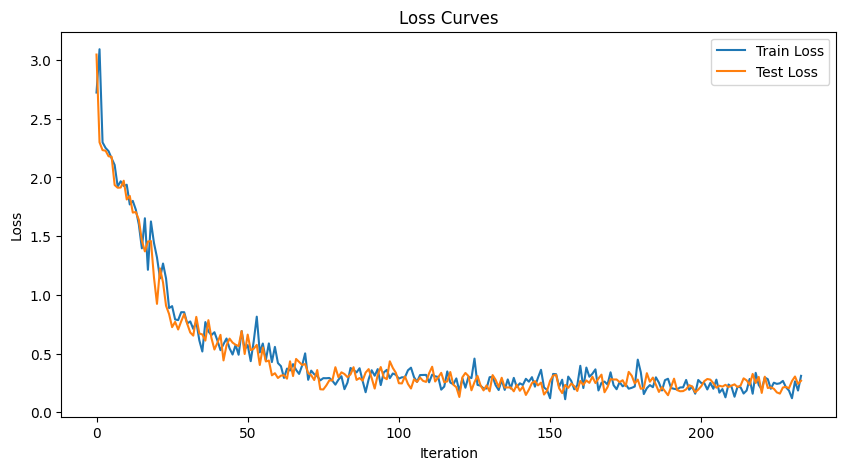

Test Set: 
    Accuracy: 94.40%


In [4]:
########### STATS ##############

def print_stats(data, targets):
    output, _ = net(data.view(data.size(0), -1))
    acc  = net.accuracy_metric(output, targets)
    #dev = np.std((targets == idx).detach().cpu().numpy()) #TODO deviation for latency encoding
    print(f"    Accuracy: {acc*100:.2f}%")

def train_printer():
    print(f"Epoch {epoch}, Iteration {img_counter}, Minibatch stats:")
    print(f"    Train Set Loss: {loss_hist[batch_counter]:.2f}")
    print(f"    Test Set Loss: {test_loss_hist[img_counter]:.2f}")
    print_stats(data, targets)
    print_stats(test_data, test_targets)
    print("\n")


##############################


# Load the network onto CUDA
net = Net().to(device)

loss = functional.loss.ce_rate_loss()
optimiser = torch.optim.Adam(net.parameters(),lr=lr)


num_epochs = 1
loss_hist = []
test_loss_hist = []

img_counter = 0 #total no. of images iterated over

#training loop
for epoch in range(num_epochs):
    batch_counter=0 #image number within current batch

    train_batches = iter(train_loader)

    #mini-batch loop
    for data, targets in train_batches: #torch.Size([128, 1, 28, 28]), torch.Size([128])

        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        net.train() #inform pytorch
        spk_rec, mem_rec = net(data.view(batch_size, -1))

        #calculate loss as cross entropy of membrane potential at each step
        loss_val = net.loss(spk_rec,targets)

        
        optimiser.zero_grad() #(reset for batch)
        loss_val.backward() #calculate backpropogation error gradient
        optimiser.step() #then update parameters

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Test set
        with torch.no_grad(): #tell pytorch to disable gradient calculation (save compute)
            net.eval()

            test_data, test_targets = next(iter(test_loader))
            test_data = test_data.to(device)
            test_targets = test_targets.to(device)

            # Test set forward pass
            test_spk, test_mem = net(test_data.view(batch_size, -1))

            # Test set loss
            test_loss = net.loss(test_spk,test_targets)
            test_loss_hist.append(test_loss.item())
            # Print train/test loss/accuracy
            if img_counter % 50 == 0:
                train_printer()
            img_counter += 1
            batch_counter +=1


###############################################################################################

# Plot Loss
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist)
plt.plot(test_loss_hist)
plt.title("Loss Curves")
plt.legend(["Train Loss", "Test Loss"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

total = 0
correct = 0

# drop_last switched to False to keep all samples
test_loader = DataLoader(mnist_test, batch_size=len(mnist_test), shuffle=True, drop_last=False)

with torch.no_grad():
  net.eval()
  for data, targets in test_loader:
    data = data.to(device)
    targets = targets.to(device)

    print("Test Set: ")
    print_stats(data,targets)

###TODO: change loss functions, latency encoding,
# can we implement STDP?

#Notes:
#training time is almost double